# COVID-19 in Marion County, IN 

## Course Project

This project consists of four levels of analysis related to the spread of COVID-19 in Marion County, IN.

- __A4: Common Analysis:__ base analysis regarding how masking policies influenced the spread of COVID-19
- __A5: Extension Plan:__ proposal of a human-centered data science question that extends the work in A4
- __A6: Presentation:__ PechaKucha-style presentation of this continued analysis
- __A7: Final Report:__ reproducible github repository & final report detailing this analysis

## A4 - Common Analysis

The goal of this analysis is to use a common dataset to answer the following...
- _How did masking policies change the progression of confirmed COVID-19 cases from February 1, 2020 - October 15, 2021 in Marion County, IN?_

Before we begin, we must import any packages needed:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import statsmodels.tsa.stattools as ts
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

### Step 0: Data Acquisition

Data was collected from several datasets including a [Kaggle Repository](https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university?select=RAW_us_confirmed_cases.csv) of US confirmed COVID-19 cases, a [CDC Dataset](https://data.cdc.gov/Policy-Surveillance/U-S-State-and-Territorial-Public-Mask-Mandates-Fro/62d6-pm5i) of masking mandates by county, and a [NYTimes Survey](https://github.com/nytimes/covid-19-data/tree/master/mask-use) on mask compliance.

- The _Kaggle Repository_ is a daily updating version (beginning on January 22, 2020) of the [COVID-19 Data Repository](https://github.com/CSSEGISandData/COVID-19) from Johns Hopkins University (JHU) showing confirmed COVID-19 cases by county.
- The _CDC Dataset_ catalogs known public mask mandates from April 10, 2020 - August 15, 2021 by county by day.
- The _NYTimes Survey_ provides a single datapoint from 250k survey responses from July 2-14, 2020 on the estimated prevalence of mask-wearing by county.

__Note:__ these files are stored in the `\data` folder with any data from the _Kaggle Repository_ stored in `\data\kaggle`

In [2]:
# read in the data
RAW_cases = pd.read_csv('data/kaggle/RAW_us_confirmed_cases.csv', low_memory=False)
mask_mandate = pd.read_csv('data/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv')
mask_compliance = pd.read_csv('data/mask-use-by-county.csv')

print('RAW_cases shape:', RAW_cases.shape)
print('mask mandate shape:', mask_mandate.shape)
print('mask compliance shape:', mask_compliance.shape)

RAW_cases shape: (3342, 695)
mask mandate shape: (1593869, 10)
mask compliance shape: (3142, 6)


In [3]:
# preview RAW_cases by County
RAW_cases.head()

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,11/26/21,11/27/21,11/28/21,11/29/21,11/30/21,12/1/21,12/2/21,12/3/21,12/4/21,12/5/21
0,Alabama,Autauga,84001001,US,USA,840,1001.0,US,32.539527,-86.644082,...,10512,10517,10517,10517,10526,10527,10531,10545,10560,10561
1,Alabama,Baldwin,84001003,US,USA,840,1003.0,US,30.727750,-87.722071,...,38061,38068,38074,38085,38104,38123,38140,38171,38195,38207
2,Alabama,Barbour,84001005,US,USA,840,1005.0,US,31.868263,-85.387129,...,3691,3694,3694,3695,3699,3700,3700,3701,3706,3708
3,Alabama,Bibb,84001007,US,USA,840,1007.0,US,32.996421,-87.125115,...,4340,4340,4340,4340,4345,4348,4352,4354,4357,4362
4,Alabama,Blount,84001009,US,USA,840,1009.0,US,33.982109,-86.567906,...,10700,10714,10715,10717,10729,10739,10756,10765,10779,10782


In [4]:
# preview mask mandates by County
mask_mandate.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
0,AL,Autauga County,1,1,4/10/2020,2,NaN,NaN,NaN,NaN
1,AL,Autauga County,1,1,4/11/2020,2,NaN,NaN,NaN,NaN
2,AL,Autauga County,1,1,4/12/2020,2,NaN,NaN,NaN,NaN
3,AL,Autauga County,1,1,4/13/2020,2,NaN,NaN,NaN,NaN
4,AL,Autauga County,1,1,4/14/2020,2,NaN,NaN,NaN,NaN


In [5]:
# preview mask compliance by County
mask_compliance.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459


### Step 1 - Analyze

__Question:__ How did masking policies change the progression of confirmed COVID-19 cases from February 1, 2020 through October 15, 2021?

__To Do:__ clean & standardize the data

__Note:__ FIPS code is a five-digit identifier which uniquely identifies counties in the United States. The FIPS code for Marion County, IN is `18097`.

In [6]:
# prep RAW_cases
# filter for Marion County, Indiana, format FIPS as integer, remove extra cols

RAW_cases = RAW_cases[RAW_cases['Province_State'] == 'Indiana']
RAW_cases = RAW_cases[RAW_cases['Admin2'] == 'Marion']
RAW_cases['FIPS'] = RAW_cases['FIPS'].astype(int)
RAW_cases = RAW_cases.drop(columns = ['Province_State', 'Admin2', 'UID', 'iso2', 'iso3', 'code3', 
                                      'Country_Region', 'Lat', 'Long_', 'Combined_Key'])

RAW_cases.head()

,FIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,11/26/21,11/27/21,11/28/21,11/29/21,11/30/21,12/1/21,12/2/21,12/3/21,12/4/21,12/5/21
779,18097,0,0,0,0,0,0,0,0,0,...,142556,142556,142556,143788,144163,144603,145083,145589,145589,145589


In [7]:
# continued prepping RAW_cases
# pivot (columns to rows), format date as datetime

cases_pivot = pd.melt(RAW_cases, id_vars = 'FIPS', var_name = 'date', value_name = 'cumulative_cases')
cases_pivot['date'] = pd.to_datetime(cases_pivot['date'])

cases_pivot.head()

,FIPS,date,cumulative_cases
0,18097,2020-01-22,0
1,18097,2020-01-23,0
2,18097,2020-01-24,0
3,18097,2020-01-25,0
4,18097,2020-01-26,0


In [8]:
# prep mask_mandate
# filter for Marion County, IN, create combined FIPS column, remove extra cols

mask_mandate = mask_mandate[mask_mandate['State_Tribe_Territory'] == 'IN']
mask_mandate = mask_mandate[mask_mandate['County_Name'] == 'Marion County']
mask_mandate['FIPS'] = (mask_mandate['FIPS_State'].astype(str) + '0' + mask_mandate['FIPS_County'].astype(str)).astype(int)
mask_mandate = mask_mandate.drop(columns = ['State_Tribe_Territory', 'County_Name', 'FIPS_State', 'FIPS_County'])
mask_mandate['date'] = pd.to_datetime(mask_mandate['date'])

mask_mandate.head()

,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation,FIPS
198043,2020-06-12,2,NaN,NaN,NaN,NaN,18097
198104,2020-06-13,2,NaN,NaN,NaN,NaN,18097
198137,2020-06-14,2,NaN,NaN,NaN,NaN,18097
198173,2020-04-10,2,NaN,NaN,NaN,NaN,18097
198174,2020-04-11,2,NaN,NaN,NaN,NaN,18097


In [9]:
# prep mask_compliance
# filter mask_compliance by FIPS code, rename FIPS column

mask_compliance = mask_compliance[mask_compliance['COUNTYFP'] == 18097]
mask_compliance.rename(columns={'COUNTYFP':'FIPS'}, inplace = True)

mask_compliance.head()

,FIPS,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
745,18097,0.051,0.053,0.116,0.232,0.548


<BarContainer object of 5 artists>

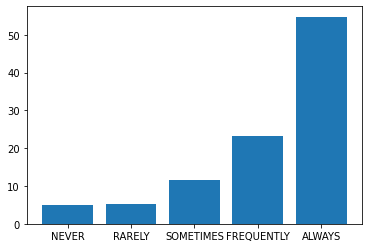

In [10]:
# visualize mask compliance

mask_compliance_pivot = pd.melt(mask_compliance, id_vars = 'FIPS', var_name = 'Compliance Level', value_name = 'Rate')

plt.bar(mask_compliance_pivot['Compliance Level'], mask_compliance_pivot['Rate'] * 100)

__To Do:__ merge dataframes on FIPS code & filter final dataframe to appropriate date range

__Note:__ We will also create a copy of the merged dataframe that is UNFILTERED to include all dates for later analysis. This will exclude the mask_compliance snapshot since joining a dataframe that updates daily with a single datapoint taken pre-mandate is very limiting.

In [11]:
# merge datasets on FIPS

marion = pd.merge(cases_pivot, mask_mandate, on = ['FIPS', 'date'], how = 'left')

marion.tail()

,FIPS,date,cumulative_cases,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
679,18097,2021-12-01,144603,NaN,NaN,NaN,NaN,NaN
680,18097,2021-12-02,145083,NaN,NaN,NaN,NaN,NaN
681,18097,2021-12-03,145589,NaN,NaN,NaN,NaN,NaN
682,18097,2021-12-04,145589,NaN,NaN,NaN,NaN,NaN
683,18097,2021-12-05,145589,NaN,NaN,NaN,NaN,NaN


In [12]:
# check date range

print(min(marion['date']))
print(max(marion['date']))

2020-01-22 00:00:00
2021-12-05 00:00:00


__To Do:__ calculate cases per day & 7-day rolling case averages to smooth the data

In [13]:
# add cases_per_day & rolling_case_avg columns
marion['cases_per_day'] = marion['cumulative_cases'].diff(periods = 1)
marion['rolling_case_avg'] = marion['cases_per_day'].rolling(window=7).mean().round()
marion.reset_index(drop = True)

marion.tail()

,FIPS,date,cumulative_cases,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation,cases_per_day,rolling_case_avg
679,18097,2021-12-01,144603,NaN,NaN,NaN,NaN,NaN,440.0,292.0
680,18097,2021-12-02,145083,NaN,NaN,NaN,NaN,NaN,480.0,361.0
681,18097,2021-12-03,145589,NaN,NaN,NaN,NaN,NaN,506.0,433.0
682,18097,2021-12-04,145589,NaN,NaN,NaN,NaN,NaN,0.0,433.0
683,18097,2021-12-05,145589,NaN,NaN,NaN,NaN,NaN,0.0,433.0


__To Do:__ investigate mask mandate data & drop any irrelevant columns
- How many days with each order_code?
- How many days of public masking? Who ordered it?

__Note:__ It seems these are state-level mandates and an `order_code` of 1 indicates public masking __was__ required. We will move forward with these assumptions.

In [14]:
# investigate mask_mandate date
marion.groupby(['order_code', 'Face_Masks_Required_in_Public', 'Source_of_Action', 'URL', 'Citation'], 
               dropna=False).size().reset_index(name='count')

,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation,count
0,1.0,Yes,Official,https://www.in.gov/gov/files/Executive%20Order...,"Ind. Exec. Order No. 20-37 (July 24, 2020)",3
1,1.0,Yes,Official,https://www.in.gov/gov/files/Executive%20Order...,"Ind. Exec. Order No. 20-39 (July 30, 2020)",27
2,1.0,Yes,Official,https://www.in.gov/gov/files/Executive%20Order...,"Ind. Exec. Order No. 20-41 (Aug. 26, 2020)",24
3,1.0,Yes,Official,https://www.in.gov/gov/files/Executive%20Order...,"Ind. Exec. Order No. 20-42 (Aug. 26, 2020)",7
4,1.0,Yes,Official,https://www.in.gov/gov/files/Executive%20Order...,"Ind. Exec. Order No. 20-43 (Sept. 24, 2020)",22
5,1.0,Yes,Official,https://www.in.gov/gov/files/Executive%20Order...,"Ind. Exec. Order No. 20-46 (Oct. 15, 2020)",14
6,1.0,Yes,Official,https://www.in.gov/gov/files/Executive-Order-2...,"Ind. Exec. Order No. 20-47 (Oct. 30, 2020)",14
7,1.0,Yes,Official,https://www.in.gov/gov/files/Executive-Order-2...,"Ind. Exec. Order No. 20-49 (Dec. 1, 2020)",12
8,1.0,Yes,Official,https://www.in.gov/gov/files/Executive-Order-2...,"Ind. Exec. Order No. 20-50 (Dec. 10, 2020)",18
9,1.0,Yes,Official,https://www.in.gov/gov/files/Executive-Order-2...,"Ind. Exec. Order No. 20-52 (Dec. 31, 2020)",4


In [15]:
# drop extra cols after investigation
marion = marion.drop(columns = ['FIPS', 'Source_of_Action', 'URL', 'Citation'])

marion.head()

,date,cumulative_cases,order_code,Face_Masks_Required_in_Public,cases_per_day,rolling_case_avg
0,2020-01-22,0,NaN,NaN,NaN,NaN
1,2020-01-23,0,NaN,NaN,0.0,NaN
2,2020-01-24,0,NaN,NaN,0.0,NaN
3,2020-01-25,0,NaN,NaN,0.0,NaN
4,2020-01-26,0,NaN,NaN,0.0,NaN


In [16]:
# lets look at this same grouping again for further clarity
marion.groupby(['order_code', 'Face_Masks_Required_in_Public'], 
               dropna=False).size().reset_index(name='count')

,order_code,Face_Masks_Required_in_Public,count
0,1.0,Yes,253
1,2.0,No,117
2,2.0,NaN,123
3,NaN,NaN,191


__Outcome:__ We are going to assume the `order_code = 2` & `Face_Masks_Required_in_Public = NaN` means no public masking was mandated. This assumes public masking  was only required for the 253 days with `order_code = 1`.

__To Do:__ create separate dataframe to store this mask mandate information & check the date range for mask requirements

In [17]:
public_masking = marion[marion['Face_Masks_Required_in_Public'] == 'Yes']

# check date range
print(min(public_masking['date']))
print(max(public_masking['date']))

#preview dataframe
public_masking.head()

2020-07-27 00:00:00
2021-04-05 00:00:00


,date,cumulative_cases,order_code,Face_Masks_Required_in_Public,cases_per_day,rolling_case_avg
187,2020-07-27,13818,1.0,Yes,118.0,139.0
188,2020-07-28,13954,1.0,Yes,136.0,138.0
189,2020-07-29,14096,1.0,Yes,142.0,143.0
190,2020-07-30,14270,1.0,Yes,174.0,146.0
191,2020-07-31,14432,1.0,Yes,162.0,146.0


__To Do:__ visualize the COVID-19 case data in Marion County, IN for the requested date range (2/1/20 - 10/15/21)

- How did new cases per day change over time?
- What about the cumulative case count?

In [18]:
# sort by date & filter to correct range (2/1/20-10/15/21 inclusive)

marion_filtered = marion.copy()
marion_filtered = marion_filtered.sort_values(by = 'date', ascending = True).reset_index(drop = True)
marion_filtered = marion_filtered.loc[(marion_filtered['date'] >= '2020-02-01') & (marion_filtered['date'] <= '2021-10-15')]

# check date range
print(min(marion_filtered['date']))
print(max(marion_filtered['date']))

2020-02-01 00:00:00
2021-10-15 00:00:00


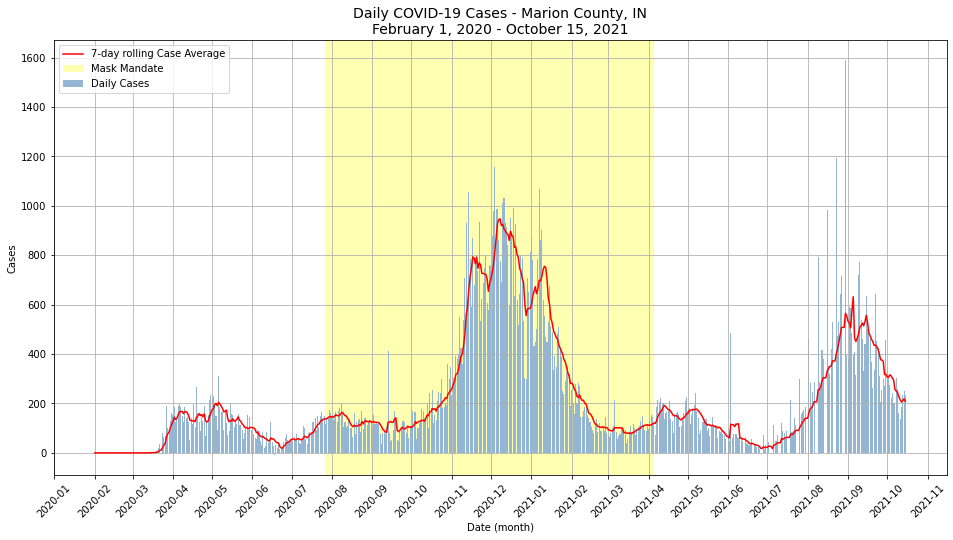

In [19]:
# daily case plot (bars + 7-day rolling avg)
fig, ax = plt.subplots(figsize=(16, 8))

ax.axvspan(min(public_masking['date']), max(public_masking['date']), 
           facecolor = 'yellow', alpha = 0.3, label = 'Mask Mandate')

plt.plot(marion_filtered['date'], marion_filtered['rolling_case_avg'], 
         label = '7-day rolling Case Average', color = 'red', lw = 1.5)
plt.bar(marion_filtered['date'], marion_filtered['cases_per_day'], label = 'Daily Cases', color = '#94B6D2', alpha = 1)


ax.legend(loc = 'upper left', prop={'size': 10})
ax.set_ylabel('Cases')
ax.set_xlabel('Date (month)')
ax.xaxis.set_major_locator(dates.MonthLocator(interval = 1))
plt.xticks(rotation = 45)
plt.grid()

plt.title('Daily COVID-19 Cases - Marion County, IN\nFebruary 1, 2020 - October 15, 2021', fontsize = 14)
plt.show()

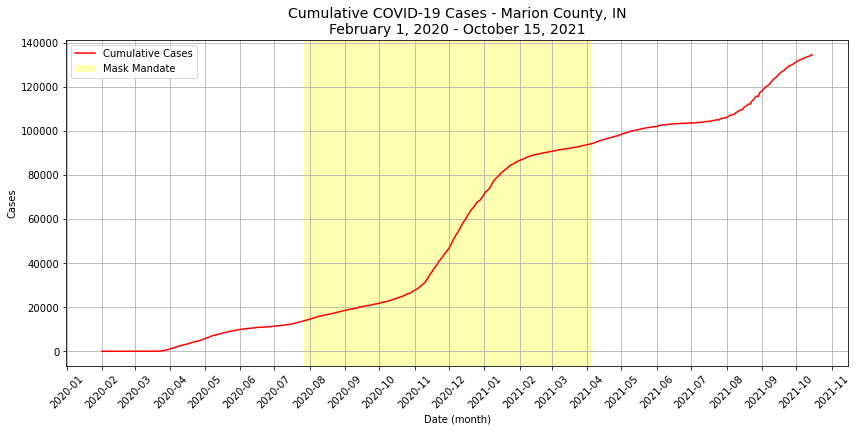

In [20]:
# cumulative case plot
fig, ax = plt.subplots(figsize=(14, 6))

ax.axvspan(min(public_masking['date']), max(public_masking['date']), 
           facecolor = 'yellow', alpha = 0.3, label = 'Mask Mandate')

plt.plot(marion_filtered['date'], marion_filtered['cumulative_cases'], color = 'red', label = 'Cumulative Cases')

ax.legend(loc = 'upper left', prop={'size': 10})
ax.set_ylabel('Cases')
ax.set_xlabel('Date (month)')
ax.xaxis.set_major_locator(dates.MonthLocator(interval = 1))
plt.xticks(rotation = 45)
plt.grid()

plt.title('Cumulative COVID-19 Cases - Marion County, IN\nFebruary 1, 2020 - October 15, 2021', fontsize = 14)
plt.show()

__To Do:__ investigate the impact of case count on infection rate, calculate at-risk population & infection rate

__Assumptions:__
- Can't get reinfected while positive (simplifying assumption: can immediately get reinfected)
- Positive for 3 days before & 10 days after positive test (as per CDC quarantine & testing guidelines)
- COVID-19 positive cases are reported the day of testing
- Every case has an identical duration
- Ignores any impact from deaths or vaccinations
- At-risk Population = Total Population - Active Cases
- Infection-rate = Active Cases / At-risk Population

In [21]:
total_pop = 977203 # from 2020 Census in 'US County Assignments.csv'

In [22]:
# turn Face_Masks_Required_in_Public into a boolean
marion['Face_Masks_Required_in_Public'] = marion['Face_Masks_Required_in_Public'] == 'Yes'

marion.head()

,date,cumulative_cases,order_code,Face_Masks_Required_in_Public,cases_per_day,rolling_case_avg
0,2020-01-22,0,NaN,False,NaN,NaN
1,2020-01-23,0,NaN,False,0.0,NaN
2,2020-01-24,0,NaN,False,0.0,NaN
3,2020-01-25,0,NaN,False,0.0,NaN
4,2020-01-26,0,NaN,False,0.0,NaN


In [23]:
# calculate 'active' contagious cases
# assumption: got tested 4 days after exposure as per CDC guidelines (were 'active' 3 days prior and 10 days after)
# assumption: positive cases are IMMEDIATELY reported day-of

# from future -> next 10 days
case_future = 10
marion['future_active_cases'] = marion['cases_per_day'].rolling(window = case_future).sum().fillna(0)

# from past -> previous 3 days
case_past = 3
marion['past_active_cases'] = marion['cases_per_day'].rolling(window = case_past).sum().shift(-case_past).fillna(0)

marion['active_cases'] = marion['future_active_cases'] + marion['past_active_cases']
marion = marion.drop(columns = ['future_active_cases', 'past_active_cases'])

marion.tail()

,date,cumulative_cases,order_code,Face_Masks_Required_in_Public,cases_per_day,rolling_case_avg,active_cases
679,2021-12-01,144603,NaN,False,440.0,292.0,4399.0
680,2021-12-02,145083,NaN,False,480.0,361.0,3651.0
681,2021-12-03,145589,NaN,False,506.0,433.0,3344.0
682,2021-12-04,145589,NaN,False,0.0,433.0,3033.0
683,2021-12-05,145589,NaN,False,0.0,433.0,3033.0


In [24]:
# calculate the at-risk population (total population - active cases where total population remains constant)

marion['at_risk_pop'] = total_pop - marion['active_cases']

In [25]:
# calculate daily & 7-day rolling average infection rates
# infection rate = cases_per_day / at_risk_population

marion['daily_infection_rate'] = (marion['cases_per_day'] / marion['at_risk_pop'] * 100.0).fillna(0)
marion['daily_infection_rate_diff'] = marion['daily_infection_rate'].diff(periods = 1)
marion['daily_infection_rate_smoothed'] = (marion['rolling_case_avg'] / marion['at_risk_pop'] * 100.0).fillna(0)

__To Do:__ visualize the COVID-19 infection rate in Marion County, IN over time for the requested date range (2/1/20 - 10/15/21)

- What was the daily infection rate?
- How did it change over time? (i.e. difference from day-to-day)

In [26]:
# sort by date & filter to correct range (2/1/20-10/15/21 inclusive)

marion_filtered = marion.copy()
marion_filtered = marion_filtered.sort_values(by = 'date', ascending = True).reset_index(drop = True)
marion_filtered = marion_filtered.loc[(marion_filtered['date'] >= '2020-02-01') & (marion_filtered['date'] <= '2021-10-15')]

# check date range
print(min(marion_filtered['date']))
print(max(marion_filtered['date']))

2020-02-01 00:00:00
2021-10-15 00:00:00


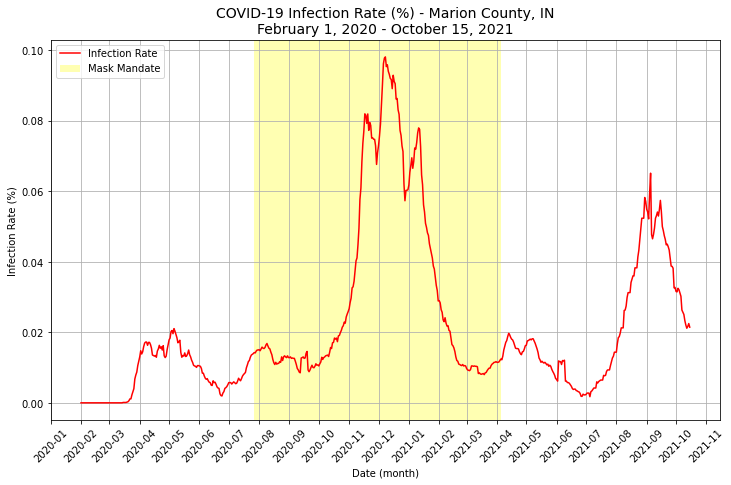

In [27]:
# daily infection rate (smoothed)
fig, ax = plt.subplots(figsize=(12, 7))

ax.axvspan(min(public_masking['date']), max(public_masking['date']), 
           facecolor = 'yellow', alpha = 0.3, label = 'Mask Mandate')

plt.plot(marion_filtered['date'], marion_filtered['daily_infection_rate_smoothed'], 
         label = 'Infection Rate', color = 'red', lw = 1.5)

ax.legend(loc = 'upper left', prop={'size': 10})
ax.set_ylabel('Infection Rate (%)')
ax.set_xlabel('Date (month)')
ax.xaxis.set_major_locator(dates.MonthLocator(interval = 1))
plt.xticks(rotation = 45)
plt.grid()

plt.title('COVID-19 Infection Rate (%) - Marion County, IN\nFebruary 1, 2020 - October 15, 2021', fontsize = 14)
plt.show()

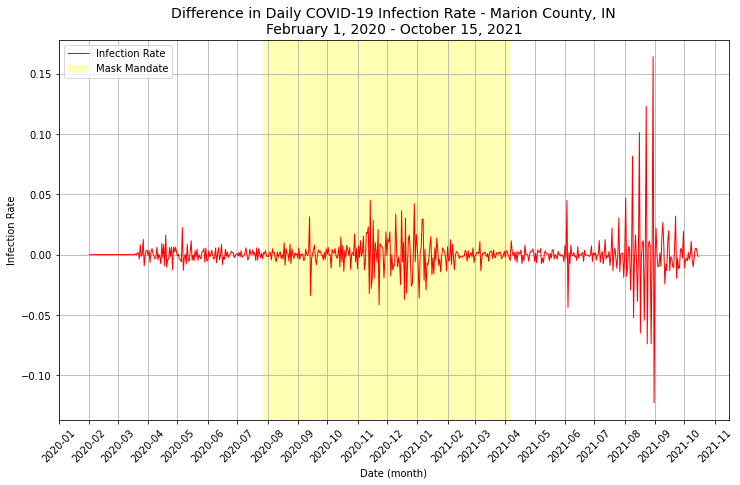

In [28]:
# difference in daily infection rate  
fig, ax = plt.subplots(figsize=(12, 7))

ax.axvspan(min(public_masking['date']), max(public_masking['date']), 
           facecolor = 'yellow', alpha = 0.3, label = 'Mask Mandate')

plt.plot(marion_filtered['date'], marion_filtered['daily_infection_rate_diff'], 
         label = 'Infection Rate', color = 'red', lw = 1)

ax.legend(loc = 'upper left', prop={'size': 10})
ax.set_ylabel('Infection Rate')
ax.set_xlabel('Date (month)')
ax.xaxis.set_major_locator(dates.MonthLocator(interval = 1))
plt.xticks(rotation = 45)
plt.grid()

plt.title('Difference in Daily COVID-19 Infection Rate - Marion County, IN\nFebruary 1, 2020 - October 15, 2021', fontsize = 14)
plt.show()

__To Do:__ show above plots as one visual & save to `infection_rate.png`

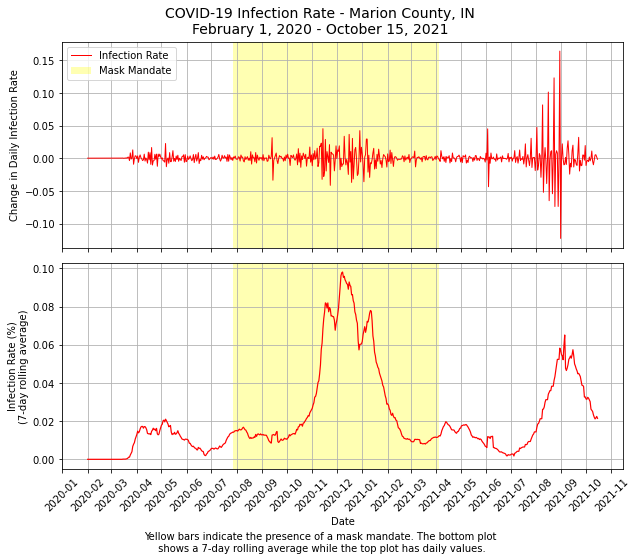

In [29]:
# change in infection rate & daily infection rate

fig, ax = plt.subplots(2, 1, sharex = True, figsize=(9, 7))
fig.suptitle('COVID-19 Infection Rate - Marion County, IN\nFebruary 1, 2020 - October 15, 2021', fontsize = 14, y = 1)
fig.subplots_adjust(hspace = 0.05)

ax[0].axvspan(min(public_masking['date']), max(public_masking['date']), 
    facecolor = 'yellow', alpha = 0.3, label = 'Mask Mandate')

ax[0].plot(marion_filtered['date'], marion_filtered['daily_infection_rate_diff'], 
         label = 'Infection Rate', color = 'red', lw = 1)

ax[0].grid()
ax[0].set_ylabel('Change in Daily Infection Rate')
ax[0].legend(loc = 'upper left', prop={'size': 10})

ax[1].axvspan(min(public_masking['date']), max(public_masking['date']), 
           facecolor = 'yellow', alpha = 0.3, label = 'Mask Mandate')

ax[1].plot(marion_filtered['date'], marion_filtered['daily_infection_rate_smoothed'], 
         label = 'Infection Rate', color = 'red', lw = 1.2)

ax[1].grid()
ax[1].set_ylabel('Infection Rate (%)\n(7-day rolling average)')
ax[1].set_xlabel('Date')
ax[1].xaxis.set_major_locator(dates.MonthLocator(interval = 1))

fig.tight_layout()
fig.subplots_adjust(top = 0.93)

txt = 'Yellow bars indicate the presence of a mask mandate. The bottom plot\n shows a 7-day rolling average while the top plot has daily values.'
fig.text(0.5, -0.08, txt, ha = 'center')

plt.xticks(rotation = 45)
plt.savefig('infection_rate.png')
plt.show()

__To Do:__ attempt to project what the infection rate would have looked like if no mask-mandate had been implemented. This involves some assumptions re: mask efficacy and a scaling up of the COVID-19 case count as if no mandate had been implemented.

__Note:__ This analysis requires significant assumptions and its implications are discussed further in `A4 - Reflection Statement.docx`. We would not recommend this approach be used to draw further conclusions without in-depth assumption validation and more supporting data.

__Assumptions:__ 
- Masks are 70% effective (on average) at COVID-19 prevention
- 100% compliance in public spaces with the mask mandate - this is a major (likely untrue) simplifying assumption
- Same assumptions from original infection rate calculation hold true

In [30]:
# calculation potential cases_per_day as if a mask mandate was never implemented
# assumption: mask wearing is 70% effective at COVID prevention
# this is how much those mask wearers could potentially REDUCE infection rate

mask_efficacy = 0.70

marion['cases_per_day_unmasked'] = np.where(marion['Face_Masks_Required_in_Public'],
                          marion['cases_per_day'] / mask_efficacy, marion['cases_per_day']).round()
marion['rolling_case_avg_unmasked'] = marion['cases_per_day_unmasked'].rolling(window=7).mean().round()

with pd.option_context('display.max_rows', 500):
    display(marion.loc[30:300])

,date,cumulative_cases,order_code,Face_Masks_Required_in_Public,cases_per_day,rolling_case_avg,active_cases,at_risk_pop,daily_infection_rate,daily_infection_rate_diff,daily_infection_rate_smoothed,cases_per_day_unmasked,rolling_case_avg_unmasked
30,2020-02-21,0,NaN,False,0.0,0.0,0.0,977203.0,0.000000,0.000000e+00,0.000000,0.0,0.0
31,2020-02-22,0,NaN,False,0.0,0.0,0.0,977203.0,0.000000,0.000000e+00,0.000000,0.0,0.0
32,2020-02-23,0,NaN,False,0.0,0.0,0.0,977203.0,0.000000,0.000000e+00,0.000000,0.0,0.0
33,2020-02-24,0,NaN,False,0.0,0.0,0.0,977203.0,0.000000,0.000000e+00,0.000000,0.0,0.0
34,2020-02-25,0,NaN,False,0.0,0.0,0.0,977203.0,0.000000,0.000000e+00,0.000000,0.0,0.0
35,2020-02-26,0,NaN,False,0.0,0.0,0.0,977203.0,0.000000,0.000000e+00,0.000000,0.0,0.0
36,2020-02-27,0,NaN,False,0.0,0.0,0.0,977203.0,0.000000,0.000000e+00,0.000000,0.0,0.0
37,2020-02-28,0,NaN,False,0.0,0.0,0.0,977203.0,0.000000,0.000000e+00,0.000000,0.0,0.0
38,2020-02-29,0,NaN,False,0.0,0.0,0.0,977203.0,0.000000,0.000000e+00,0.000000,0.0,0.0
39,2020-03-01,0,NaN,False,0.0,0.0,0.0,977203.0,0.000000,0.000000e+00,0.000000,0.0,0.0


In [31]:
# calculate 'active' contagious cases AS if a mask mandate was never implemented
# same assumptions regarding COVID-19 infection timeline as in the original 'active_cases' calculation

marion['future_active_cases_unmasked'] = marion['cases_per_day_unmasked'].rolling(window = case_future).sum().fillna(0)
marion['past_active_cases_unmasked'] = marion['cases_per_day_unmasked'].rolling(window = case_past).sum().shift(-case_past).fillna(0)
marion['active_cases_unmasked'] = marion['future_active_cases_unmasked'] + marion['past_active_cases_unmasked']
marion = marion.drop(columns = ['future_active_cases_unmasked', 'past_active_cases_unmasked'])

marion.tail()

,date,cumulative_cases,order_code,Face_Masks_Required_in_Public,cases_per_day,rolling_case_avg,active_cases,at_risk_pop,daily_infection_rate,daily_infection_rate_diff,daily_infection_rate_smoothed,cases_per_day_unmasked,rolling_case_avg_unmasked,active_cases_unmasked
679,2021-12-01,144603,NaN,False,440.0,292.0,4399.0,972804.0,0.045230,0.006682,0.030016,440.0,292.0,4399.0
680,2021-12-02,145083,NaN,False,480.0,361.0,3651.0,973552.0,0.049304,0.004074,0.037081,480.0,361.0,3651.0
681,2021-12-03,145589,NaN,False,506.0,433.0,3344.0,973859.0,0.051958,0.002654,0.044462,506.0,433.0,3344.0
682,2021-12-04,145589,NaN,False,0.0,433.0,3033.0,974170.0,0.000000,-0.051958,0.044448,0.0,433.0,3033.0
683,2021-12-05,145589,NaN,False,0.0,433.0,3033.0,974170.0,0.000000,0.000000,0.044448,0.0,433.0,3033.0


In [32]:
# at-risk population for the unmasked group

marion['at_risk_pop_unmasked'] = total_pop - marion['active_cases_unmasked']

In [33]:
# 7-day rolling average infection rates for the unmasked population

marion['daily_infection_rate_unmasked_smoothed'] = (marion['rolling_case_avg_unmasked'] / marion['at_risk_pop_unmasked'] * 100.0).fillna(0)

__To Do:__ visualize the difference in infection rate as if masks were 70% effective (i.e. mandates caused a ~30% reduction in COVID-19 cases than would have otherwise occurred).

In [34]:
# sort by date & filter to correct range (2/1/20-10/15/21 inclusive)

marion_filtered = marion.copy()
marion_filtered = marion_filtered.sort_values(by = 'date', ascending = True).reset_index(drop = True)
marion_filtered = marion_filtered.loc[(marion_filtered['date'] >= '2020-02-01') & (marion_filtered['date'] <= '2021-10-15')]

# check date range
print(min(marion_filtered['date']))
print(max(marion_filtered['date']))

2020-02-01 00:00:00
2021-10-15 00:00:00


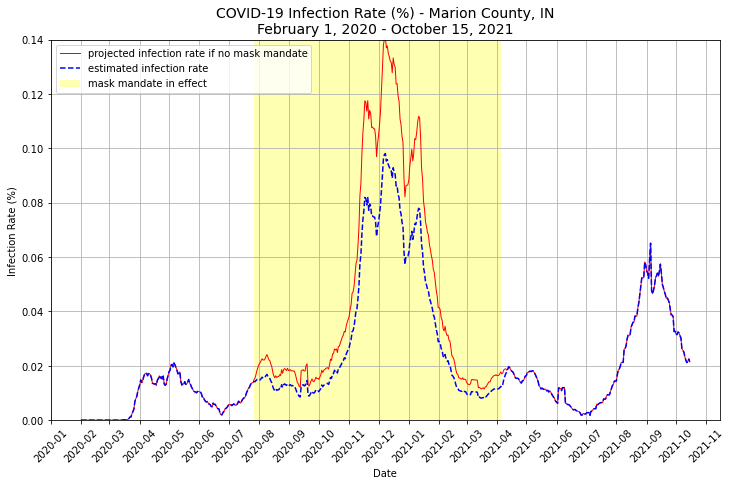

In [35]:
# daily infection rate w/ & w/o masking plot (smoothed)
fig, ax = plt.subplots(figsize=(12, 7))

ax.axvspan(min(public_masking['date']), max(public_masking['date']), 
           facecolor = 'yellow', alpha = 0.3, label = 'mask mandate in effect')

plt.plot(marion_filtered['date'], marion_filtered['daily_infection_rate_unmasked_smoothed'], 
         label = 'projected infection rate if no mask mandate', color = 'red', lw = 1)
plt.plot(marion_filtered['date'], marion_filtered['daily_infection_rate_smoothed'], 
         label = 'estimated infection rate', color = 'blue', lw = 1.5, ls = '--')

ax.legend(loc = 'upper left', prop={'size': 10})
ax.set_ylabel('Infection Rate (%)')
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(dates.MonthLocator(interval = 1))
plt.xticks(rotation = 45)
ax.set_ylim([0.00, 0.14])
plt.grid()

plt.title('COVID-19 Infection Rate (%) - Marion County, IN\nFebruary 1, 2020 - October 15, 2021', fontsize = 14)
plt.show()

## A5-7 - Extension, Presentation, Report

The goal of this analysis is to extend the __Common Analysis__ by asking a human-centered data science question that builds on prior work. 

The motivation, research question, & proposed methodology for this extension can be found in `A5 - Extension Plan.docx`. This document also discusses publically available data that can be used to answer this question as well as potential unknowns, dependencies, or sources of bias that may limit our ability to get a satisfactory answer.  The methodology is outlined below here and results are presented in `A6 - Presentation.pptx` and `A7 - Final Report.docx`.

This continued analysis involves a study of outcome data related to COVID-19 in Marion County, IN - specifically focusing on the following questions...

- _How did hospital occupancy impact COVID-19 outcomes?_
- _Is there any link between periods of peak hospitalizations and increased Case Fatality or Vaccination Rate?_

### Additional Data Acquisition

Additional data was collected to build-on the prior datasets discussed in `Step 0: Data Acquisition`. 


Data was collected from several datasets including data on hospitalizations from the [Marion County COVID-19 Dashboard](https://marionhealth.org/coviddashboard/DR4417-COVID-Public-Information-Dashboard.html), another dataset in the same [Kaggle Repository](https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university?select=RAW_us_deaths.csv) as earlier that gives US COVID-19 daily deaths by county.

- The _hospitalization_ data was pulled from the 'Daily Hospitalizations' tab of the [Marion County COVID-19 Dashboard](https://marionhealth.org/coviddashboard/DR4417-COVID-Public-Information-Dashboard.html) using [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/) as this data is __only__ publicly available via a dashboard. The output of WebPlotDigitzer was spot-checked using actual values from the dashboard.

__Note:__ these files are stored in the `\data` folder with any additional data from the _Kaggle Repository_ stored in `\data\kaggle`

In [36]:
# read in hospitalizations data
hospitalizations = pd.read_csv('data/hospitalizations.csv', low_memory=False)

print('hospitalizations shape:', hospitalizations.shape)

hospitalizations shape: (638, 2)


In [37]:
# format hospitalizations
# turn column into datetime, find date range, round hospitalization count, preview data

hospitalizations.rename(columns={'Date':'date'}, inplace = True)
hospitalizations['date'] = pd.to_datetime(hospitalizations['date'])
hospitalizations['rolling_hospitalization_avg'] = hospitalizations['7-day hospitalizations average'].round()

print(min(hospitalizations['date']))
print(max(hospitalizations['date']))

hospitalizations.head()

2020-03-01 00:00:00
2021-11-29 00:00:00


,date,7-day hospitalizations average,rolling_hospitalization_avg
0,2020-03-01,0.793135,1.0
1,2020-03-02,1.529821,2.0
2,2020-03-03,2.487512,2.0
3,2020-03-04,3.432926,3.0
4,2020-03-05,4.267836,4.0


In [38]:
# read in deaths data
RAW_deaths = pd.read_csv('data/kaggle/RAW_us_deaths.csv', low_memory=False)

print('deaths shape:', RAW_deaths.shape)

deaths shape: (3342, 696)


In [39]:
# reformat RAW_deaths same as RAW_cases was formatted earlier & pivot to 'deaths_pivot'

RAW_deaths = RAW_deaths[RAW_deaths['Province_State'] == 'Indiana']
RAW_deaths = RAW_deaths[RAW_deaths['Admin2'] == 'Marion']
RAW_deaths['FIPS'] = RAW_deaths['FIPS'].astype(int)
RAW_deaths = RAW_deaths.drop(columns = ['Province_State', 'Admin2', 'UID', 'iso2', 'iso3', 'code3', 
                                      'Country_Region', 'Lat', 'Long_', 'Combined_Key', 'Population'])


# pivot (columns to rows) RAW_deaths
# format date as datetime
deaths_pivot = pd.melt(RAW_deaths, id_vars = 'FIPS', var_name = 'date', value_name = 'cumulative_deaths')
deaths_pivot['date'] = pd.to_datetime(deaths_pivot['date'])

# add deaths_per_day & rolling_death_avg columns
deaths_pivot['deaths_per_day'] = deaths_pivot['cumulative_deaths'].diff(periods = 1)
deaths_pivot['rolling_death_avg'] = deaths_pivot['deaths_per_day'].rolling(window=7).mean().round()
deaths_pivot['deaths_per_day_diff'] = deaths_pivot['deaths_per_day'].diff(periods = 1)
deaths_pivot.reset_index(drop = True)

deaths_pivot.head()

,FIPS,date,cumulative_deaths,deaths_per_day,rolling_death_avg,deaths_per_day_diff
0,18097,2020-01-22,0,NaN,NaN,NaN
1,18097,2020-01-23,0,0.0,NaN,NaN
2,18097,2020-01-24,0,0.0,NaN,0.0
3,18097,2020-01-25,0,0.0,NaN,0.0
4,18097,2020-01-26,0,0.0,NaN,0.0


__To Do:__ merge the new extension dataframes (deaths + hospitalizations) with the `marion` dataframe from earlier

__Note:__ we will also drop some unneccessary columns & truncate the dataset on the range of dates for which we have hospitalization data (3/1/20 - 12/1/21)

In [40]:
# merge on FIPS w/ hospitalizations & deaths on date
marion = pd.merge(marion, deaths_pivot, on = 'date', how = 'left')
marion = pd.merge(marion, hospitalizations, on = 'date', how = 'left')

marion.head()

,date,cumulative_cases,order_code,Face_Masks_Required_in_Public,cases_per_day,rolling_case_avg,active_cases,at_risk_pop,daily_infection_rate,daily_infection_rate_diff,...,active_cases_unmasked,at_risk_pop_unmasked,daily_infection_rate_unmasked_smoothed,FIPS,cumulative_deaths,deaths_per_day,rolling_death_avg,deaths_per_day_diff,7-day hospitalizations average,rolling_hospitalization_avg
0,2020-01-22,0,NaN,False,NaN,NaN,0.0,977203.0,0.0,NaN,...,0.0,977203.0,0.0,18097,0,NaN,NaN,NaN,NaN,NaN
1,2020-01-23,0,NaN,False,0.0,NaN,0.0,977203.0,0.0,0.0,...,0.0,977203.0,0.0,18097,0,0.0,NaN,NaN,NaN,NaN
2,2020-01-24,0,NaN,False,0.0,NaN,0.0,977203.0,0.0,0.0,...,0.0,977203.0,0.0,18097,0,0.0,NaN,0.0,NaN,NaN
3,2020-01-25,0,NaN,False,0.0,NaN,0.0,977203.0,0.0,0.0,...,0.0,977203.0,0.0,18097,0,0.0,NaN,0.0,NaN,NaN
4,2020-01-26,0,NaN,False,0.0,NaN,0.0,977203.0,0.0,0.0,...,0.0,977203.0,0.0,18097,0,0.0,NaN,0.0,NaN,NaN


In [41]:
# drop some cols, truncate on hospitalization date range
marion = marion.drop(columns = ['FIPS', '7-day hospitalizations average'])
marion = marion.loc[(marion['date'] >= '2020-03-01') & (marion['date'] <= '2021-12-01')]

print(min(marion['date']))
print(max(marion['date']))

marion.head()

2020-03-01 00:00:00
2021-12-01 00:00:00


,date,cumulative_cases,order_code,Face_Masks_Required_in_Public,cases_per_day,rolling_case_avg,active_cases,at_risk_pop,daily_infection_rate,daily_infection_rate_diff,...,cases_per_day_unmasked,rolling_case_avg_unmasked,active_cases_unmasked,at_risk_pop_unmasked,daily_infection_rate_unmasked_smoothed,cumulative_deaths,deaths_per_day,rolling_death_avg,deaths_per_day_diff,rolling_hospitalization_avg
39,2020-03-01,0,NaN,False,0.0,0.0,0.0,977203.0,0.0,0.0,...,0.0,0.0,0.0,977203.0,0.0,0,0.0,0.0,0.0,1.0
40,2020-03-02,0,NaN,False,0.0,0.0,0.0,977203.0,0.0,0.0,...,0.0,0.0,0.0,977203.0,0.0,0,0.0,0.0,0.0,2.0
41,2020-03-03,0,NaN,False,0.0,0.0,1.0,977202.0,0.0,0.0,...,0.0,0.0,1.0,977202.0,0.0,0,0.0,0.0,0.0,2.0
42,2020-03-04,0,NaN,False,0.0,0.0,1.0,977202.0,0.0,0.0,...,0.0,0.0,1.0,977202.0,0.0,0,0.0,0.0,0.0,3.0
43,2020-03-05,0,NaN,False,0.0,0.0,1.0,977202.0,0.0,0.0,...,0.0,0.0,1.0,977202.0,0.0,0,0.0,0.0,0.0,4.0


__To Do:__ visualize cases, hospitalizations, & deaths over the time series from 3/1/20 - 12/1/21

Text(0.5, 1.0, 'COVID-19 - Marion County, IN\nMarch 1, 2020 - December 1, 2021')

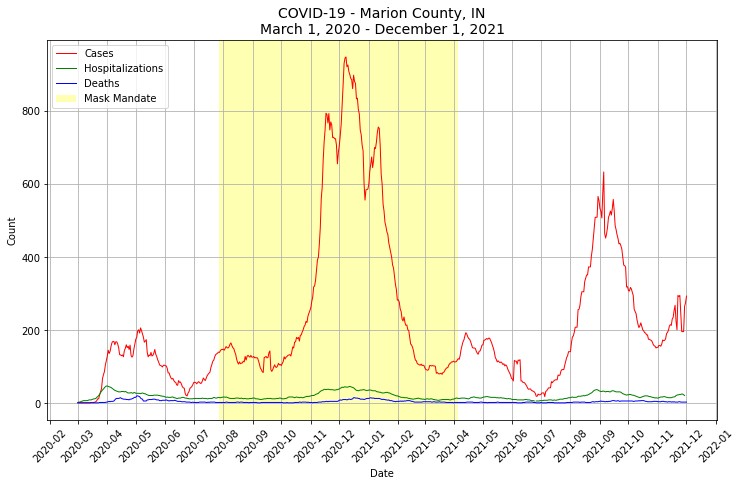

In [42]:
# cases, hospitalizations, deaths
fig, ax = plt.subplots(figsize=(12, 7))

ax.axvspan(min(public_masking['date']), max(public_masking['date']), 
           facecolor = 'yellow', alpha = 0.3, label = 'Mask Mandate')

plt.plot(marion['date'], marion['rolling_case_avg'], label = 'Cases', color = 'red', lw = 1)
plt.plot(marion['date'], marion['rolling_hospitalization_avg'], label = 'Hospitalizations', color = 'green', lw = 1)
plt.plot(marion['date'], marion['rolling_death_avg'], label = 'Deaths', color = 'blue', lw = 1)

ax.legend(loc = 'upper left', prop={'size': 10})
ax.set_ylabel('Count')
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(dates.MonthLocator(interval = 1))
plt.xticks(rotation = 45)
plt.grid()

plt.title('COVID-19 - Marion County, IN\nMarch 1, 2020 - December 1, 2021', fontsize = 14)

Text(0.5, 1.0, 'COVID-19 - Marion County, IN\nMarch 1, 2020 - December 1, 2021')

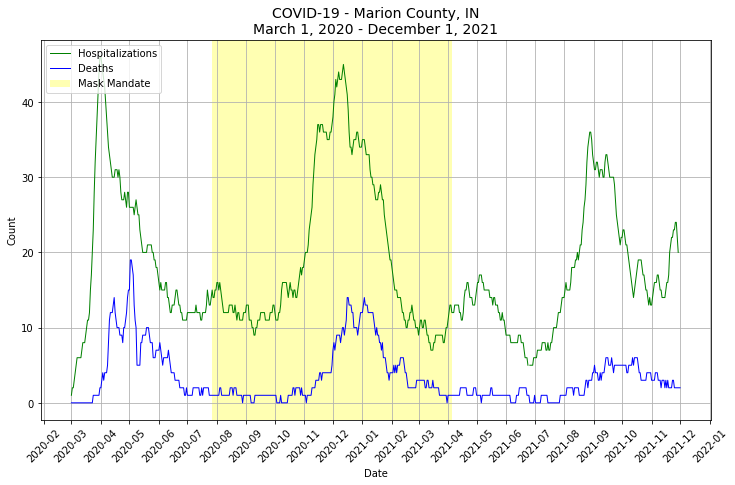

In [43]:
# zoom in on just hospitalizations & deaths
fig, ax = plt.subplots(figsize=(12, 7))

ax.axvspan(min(public_masking['date']), max(public_masking['date']), 
           facecolor = 'yellow', alpha = 0.3, label = 'Mask Mandate')

plt.plot(marion['date'], marion['rolling_hospitalization_avg'], label = 'Hospitalizations', color = 'green', lw = 1)
plt.plot(marion['date'], marion['rolling_death_avg'], label = 'Deaths', color = 'blue', lw = 1)

ax.legend(loc = 'upper left', prop={'size': 10})
ax.set_ylabel('Count')
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(dates.MonthLocator(interval = 1))
plt.xticks(rotation = 45)
plt.grid()

plt.title('COVID-19 - Marion County, IN\nMarch 1, 2020 - December 1, 2021', fontsize = 14)

### Pearson Correlation & Augmented Dickey-Fuller Test

__To Do:__ validate assumptions on stationarity (seasonality + trend) using the __Augmented Dickey-Fuller__ (ADF) test. Read more on stationarity in time-series and the ADF test [here](https://www.machinelearningplus.com/time-series/time-series-analysis-python/).

__Note:__ the null hypothesis for the ADF test is that the time series is non-stationary, therefore if p-value is low - we will reject the null and move forward as if the time series is stationary.

In [44]:
# augmented dickey-fuller t-test for stationarity in time series data
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
# https://machinelearningmastery.com/time-series-data-stationary-python/

def ADF(X):
    X = X.fillna(method='ffill').values
    
    result = ts.adfuller(X)
    
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [45]:
# ADF for cases_per_day -> fail to reject the null
ADF(marion['cases_per_day'])

ADF Statistic: -2.190564
p-value: 0.209688
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [46]:
# ADF for deaths_per_day -> fail to reject the null
ADF(marion['deaths_per_day'])

ADF Statistic: -2.263730
p-value: 0.183933
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [47]:
# ADF for rolling_case_avg -> reject the null
ADF(marion['rolling_case_avg'])

ADF Statistic: -3.051784
p-value: 0.030333
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [48]:
# ADF for rolling_death_avg -> reject the null
ADF(marion['rolling_death_avg'])

ADF Statistic: -3.058381
p-value: 0.029790
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [49]:
# ADF for rolling_hospitalization_avg -> reject the null
ADF(marion['rolling_hospitalization_avg'])

ADF Statistic: -2.974434
p-value: 0.037352
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


__Interpretation:__ as seen above, smoothed case + death data with a 7-day rolling average allows us to reject the null and assume stationarity for these time series. For hospitalizations, we only have the smoothed data but it still passes the ADF test. This makes sense as there was clearly some pattern in the data due to reporting inconsistencies throughout each week - we are not surprised to see that smoothing the data reduces stationarity.

__To Do:__ now that we have data that is stationary, we can calculate the Pearson R correlation. Read [here](https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9) for more about Pearson R in time series analysis.

__Note:__ our hypothesis is hospitalizations may be a better predictor of COVID-19 deaths than cases. This could result from underreported cases (i.e. asymptomatic individuals, lack of testing).

In [50]:
# pearson R correlation

def pearson_r(X,Y):
    
    X = X.fillna(method='ffill')
    Y = Y.fillna(method='ffill')
    
    try:
        r, p = stats.pearsonr(X,Y)
    except:
        X = X.fillna(0)
        Y = Y.fillna(0)
        r, p = stats.pearsonr(X,Y)
    
    print(f"pearson r: {r} & p-value: {p}")

In [51]:
print('Correlation b/t hospitalizations & deaths')
pearson_r(marion['rolling_hospitalization_avg'], marion['rolling_death_avg'])

print('Correlation b/t cases & deaths')
pearson_r(marion['rolling_case_avg'], marion['rolling_death_avg'])

Correlation b/t hospitalizations & deaths
pearson r: 0.6316826684288762 & p-value: 1.1030399388035392e-72
Correlation b/t cases & deaths
pearson r: 0.5325438143530683 & p-value: 3.1089365083229945e-48


__Interpretation:__ as seen above, both cases-deaths & hospitalizations-deaths have a p-value <0.05 and a fairly strong Pearson R correlation. As anticipated, there is a stronger relationship between hospitalizations & deaths - this is expected as hospitalizations are assumed to be a more robust metric than cases and are unlikely to go undetected.

__To Do:__ Pearson R is a good measure of global synchrony between datasets but doesn't provide much insight into signal dynamics (i.e. can't tell which signal is lagging vs. leading). For this analysis - we will assume hospitalizations lead deaths as this is the only metric that makes sense intuitively and we can see it from our hospitalizations + deaths visualization above.

### Time-Lagged Cross Correlation

__To Do:__ now we wanted to calculate the anticipated lag between hospitalizations & deaths. This can be measured through a Time-Lagged Cross Correlation (TLCC) between the two signals - more info [here](https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9). This lag will be calculated by the time period at which the peak Pearson R correlation is found between the signals.

__Purpose:__ being able to identify the typical amount of lag between hospitalizations & deaths can be used to better anticipate ICU staffing needs and planning.

In [52]:
# time-lagged cross correlation
def crosscorr(a, b, num_days):
    lag = 0
    lag_list = []
    r_list = []
    p_list = []
    
    while lag < num_days:
        a_shift = a.shift(lag)
        r, p = stats.pearsonr(a_shift.fillna(0), b.fillna(0))
        
        lag_list.append(lag)
        r_list.append(r)
        p_list.append(p)
        
        lag += 1

    return lag_list, r_list, p_list

In [53]:
lag,r,p = crosscorr(marion['rolling_hospitalization_avg'], marion['rolling_death_avg'], 60)
max_lag = np.argmax(r)

print('Max Pearson R value:', max(r))
print('Lag (days):', max_lag)

Max Pearson R value: 0.8522237450706328
Lag (days): 16


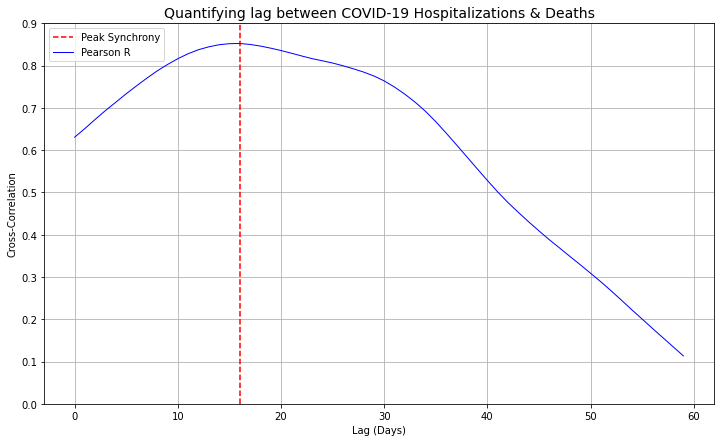

In [54]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.axvline(max_lag,color='red',linestyle='--',label='Peak Synchrony')
plt.plot(lag, r, label = 'Pearson R', color = 'blue', lw = 1)

ax.legend(loc = 'upper left', prop={'size': 10})
ax.set_ylabel('Cross-Correlation')
ax.set_xlabel('Lag (Days)')
plt.ylim(0, 0.9)
plt.grid()

plt.title('Quantifying lag between COVID-19 Hospitalizations & Deaths'.format(max_lag), fontsize = 14)
plt.show()

### Case-Fatality Ratio

__Case Fatality Ratio (CFR):__ represents the proportion of cases that will eventually result in a death from a disease [Wikipedia](https://en.wikipedia.org/wiki/Case_fatality_rate). 

__Challenge:__ as the paper cited [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7569625/) discusses, CFR represents the proportion of cases that eventually die from a disease "once an epidemic has ended" - this is not information we presently have. The paper proposes calculating CFR over time as `deaths at day X / cases at day (X-a)` where a represents the average time period from case confirmation to death. Unfortunately - due to reporting challenges, early lack of testing, and only having aggregate data - this is impossible for our analysis as the new proposed formula is simply not robust enough and shows massive, unexpected swings in CFR even pre-vaccine availability. 

__Note:__ all Indiana residents age 16+ became eligible for vaccination on 3/31/21 [source](https://www.indystar.com/story/news/health/2021/03/23/indiana-vaccine-plan-hoosiers-over-16-eligible-vaccines-march-31/4726997001/).

In [55]:
all_eligible_date = pd.to_datetime('2021-03-31')

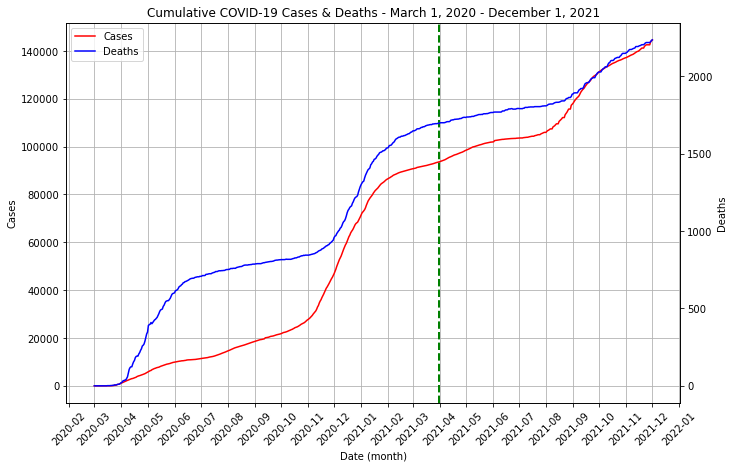

In [56]:
# cumulative cases & deaths

fig = plt.figure(figsize=(11, 7))
ax1 = fig.add_subplot(111)

ax1.axvline(all_eligible_date, color='green',linestyle='--', label='Vaccinations Open to All Adults', lw = 2)

lns1 = ax1.plot(marion['date'], marion['cumulative_cases'], color = 'red', label = 'Cases')
ax2 = ax1.twinx()
lns2 = ax2.plot(marion['date'], marion['cumulative_deaths'], color = 'blue', label = 'Deaths')

# added these three lines
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax1.grid()
ax1.tick_params('x', labelrotation=45) 

ax1.set_xlabel('Date (month)')
ax1.set_ylabel('Cases')
ax2.set_ylabel('Deaths')
ax1.xaxis.set_major_locator(dates.MonthLocator(interval = 1))

plt.xticks(rotation = 45)
plt.title('Cumulative COVID-19 Cases & Deaths - March 1, 2020 - December 1, 2021', fontsize = 12)

plt.show()

__Interpretation:__ we expect to see relatively similar slopes across the time series for cases + deaths with some lag-time. However, the slope for deaths starts much higher than that for cases early-on before narrowing even pre-vaccine. This is unexpected. This behavior is likely indicative of early testing shortages and unrecorded asymptomatic transmission. We do not have the appropriate data available to make any robust calculations on CFR over time.

__Note:__ double y-axis on the above plot

### Hospitalizations & ICU Occupancy Rate

__To Do:__ read in [data](https://hub.mph.in.gov/dataset/covid-19-bed-and-vent-usage-by-day) from the Indiana Department of Health (IDOH) on state-level ICU & ventilator occupancy & investigate trends throughout the course of the pandemic.  

__Note:__ this is a state-level analysis as data for occupancy rate was only available at the state-level. Nevertheless, any interpretations should generalize well to Marion County as Marion accounts for 1/6 of Indiana's population and contains Indianapolis, the largest metropolitan area in the state. This assumption was validated by spot-checking a few datapoints with a [dashboard](https://data.statesmanjournal.com/covid-19-hospital-capacity/facility/indiana-university-health/150056/) from the Statesman Journal.

__Purpose:__ in lieu of being able to investigate CFR over time - this is a good proxy to understand what is going on and to better inform the COVID-19 response in the area. It is important to note that hospitals can go on diversion or 'fill-up' not due to lack of beds but due to inadequate staffing ([source](https://www.cnn.com/2021/09/13/health/rationing-care-hospital-beds-staff-explainer-wellness/index.html)).

In [57]:
# read in occupancy data
IN_hospitals = pd.read_csv('data/covid_report_bedvent_date.csv', low_memory=False)

print('shape:', IN_hospitals.shape)

shape: (646, 15)


In [58]:
# process the data
# reformat date, drop date range for which no data is available
IN_hospitals.rename(columns={'DATE':'date'}, inplace = True) # start getting data on 4/15/20
IN_hospitals['date'] = pd.to_datetime(IN_hospitals['date'])
IN_hospitals = IN_hospitals.loc[(IN_hospitals['date'] >= '2020-04-15') & (IN_hospitals['date'] <= '2021-12-01')]

print(min(IN_hospitals['date']))
print(max(IN_hospitals['date']))

IN_hospitals.tail()

2020-04-15 00:00:00
2021-12-01 00:00:00


,date,BEDS_ICU_TOTAL,BEDS_ICU_OCCUPIED_COVID_19,BEDS_ICU_NO_OCCUPIED_COVID_19,BEDS_AVAILABLE_ICU_BEDS_TOTAL,VENTS_TOTAL,VENTS_ALL_USE_COVID_19,VENTS_NON_COVID_PTS_ON_VENTS,VENTS_ALL_AVAILABLE_VENTS_NOT_IN_USE,PCT_BEDS_ICU_OCCUPIED_COVID_19,PCT_BEDS_ICU_NO_OCCUPIED_COVID_19,PCT_BEDS_AVAILABLE_ICU_BEDS_TOTAL,PCT_VENTS_ALL_USE_COVID_19,PCT_VENTS_NON_COVID_PTS_ON_VENTS,PCT_VENTS_ALL_AVAILABLE_VENTS_NOT_IN_USE
640,2021-11-27,2271,505,1207,559,2781,210,539,2032,22.24,53.15,24.61,7.55,19.38,73.07
641,2021-11-28,2275,513,1208,554,2776,213,545,2018,22.55,53.10,24.35,7.67,19.63,72.69
642,2021-11-29,2278,550,1145,583,2781,247,564,1970,24.14,50.26,25.59,8.88,20.28,70.84
643,2021-11-30,2275,591,1212,472,2778,247,571,1960,25.98,53.27,20.75,8.89,20.55,70.55
644,2021-12-01,2285,601,1249,435,2768,255,566,1947,26.30,54.66,19.04,9.21,20.45,70.34


__To Do:__ compute ICU occupancy & rolling averages for COVID & non-COVID patients

In [59]:
# get occupancy - used BED
IN_hospitals['ICU_occupancy'] = (1 - IN_hospitals['BEDS_AVAILABLE_ICU_BEDS_TOTAL'] / IN_hospitals['BEDS_ICU_TOTAL']) * 100
IN_hospitals['ICU_occupancy_covid'] = IN_hospitals['BEDS_ICU_OCCUPIED_COVID_19'] / IN_hospitals['BEDS_ICU_TOTAL'] * 100
IN_hospitals['ICU_occupancy_noncovid'] = IN_hospitals['BEDS_ICU_NO_OCCUPIED_COVID_19'] / IN_hospitals['BEDS_ICU_TOTAL'] * 100
IN_hospitals['vent_occupancy'] = (1- IN_hospitals['VENTS_ALL_AVAILABLE_VENTS_NOT_IN_USE'] / IN_hospitals['VENTS_TOTAL']) * 100

# get rolling averages
IN_hospitals['rolling_ICU_occupancy_covid'] = IN_hospitals['ICU_occupancy_covid'].rolling(window=7).mean().round()
IN_hospitals['rolling_ICU_occupancy_noncovid'] = IN_hospitals['ICU_occupancy_noncovid'].rolling(window=7).mean().round()
IN_hospitals['rolling_ICU_occupancy'] = IN_hospitals['ICU_occupancy'].rolling(window=7).mean().round()
IN_hospitals['rolling_vent_occupancy'] = IN_hospitals['vent_occupancy'].rolling(window=7).mean().round()

IN_hospitals.head()

,date,BEDS_ICU_TOTAL,BEDS_ICU_OCCUPIED_COVID_19,BEDS_ICU_NO_OCCUPIED_COVID_19,BEDS_AVAILABLE_ICU_BEDS_TOTAL,VENTS_TOTAL,VENTS_ALL_USE_COVID_19,VENTS_NON_COVID_PTS_ON_VENTS,VENTS_ALL_AVAILABLE_VENTS_NOT_IN_USE,PCT_BEDS_ICU_OCCUPIED_COVID_19,...,PCT_VENTS_NON_COVID_PTS_ON_VENTS,PCT_VENTS_ALL_AVAILABLE_VENTS_NOT_IN_USE,ICU_occupancy,ICU_occupancy_covid,ICU_occupancy_noncovid,vent_occupancy,rolling_ICU_occupancy_covid,rolling_ICU_occupancy_noncovid,rolling_ICU_occupancy,rolling_vent_occupancy
49,2020-04-15,2926,696,924,1306,2961,427,297,2237,23.79,...,10.03,75.55,55.365687,23.786740,31.578947,24.451199,NaN,NaN,NaN,NaN
50,2020-04-16,2915,639,918,1358,3027,417,326,2284,21.92,...,10.77,75.45,53.413379,21.921098,31.492281,24.545755,NaN,NaN,NaN,NaN
51,2020-04-17,2837,663,825,1349,3080,359,334,2387,23.37,...,10.84,77.50,52.449771,23.369757,29.080014,22.500000,NaN,NaN,NaN,NaN
52,2020-04-18,2872,649,878,1345,3117,344,332,2441,22.60,...,10.65,78.31,53.168524,22.597493,30.571031,21.687520,NaN,NaN,NaN,NaN
53,2020-04-19,2863,670,833,1360,3104,353,342,2409,23.40,...,11.02,77.61,52.497380,23.402026,29.095355,22.390464,NaN,NaN,NaN,NaN


__To Do:__ visualize any potential trend in hospitalizations

__Note:__ we would expect an increase in hospitalizations during the 1st COVID-19 peak (mid-late November 2020) and again during the 2nd wave in late August 2021. Local news stories ([here](https://www.usnews.com/news/best-states/indiana/articles/2021-09-08/covid-19-patients-strain-indiana-hospitals-as-virus-surges)) & [here](https://www.wthr.com/article/news/verify/yes-many-indianapolis-area-hospitals-have-been-turning-away-ambulances-because-their-ers-and-icus-are-too-full-verify/531-28e2216c-dc3f-4b4d-ae3c-f02f30634439)) mention ICU diversions and cancellation of elective procedures during this time. This would have an impact on staffing & all patients (COVID & non-COVID) alike.

In [60]:
x = np.array(IN_hospitals['date'].index).reshape(-1, 1)
y = IN_hospitals['rolling_ICU_occupancy'].fillna(0).values.reshape(-1, 1)

lm = LinearRegression().fit(x,y)
preds = lm.predict(x)
print(lm.coef_)

[[0.01908766]]


Text(0.5, 1.0, 'ICU Hospitalizations - Indiana\nApril 8, 2020 - December 1, 2021')

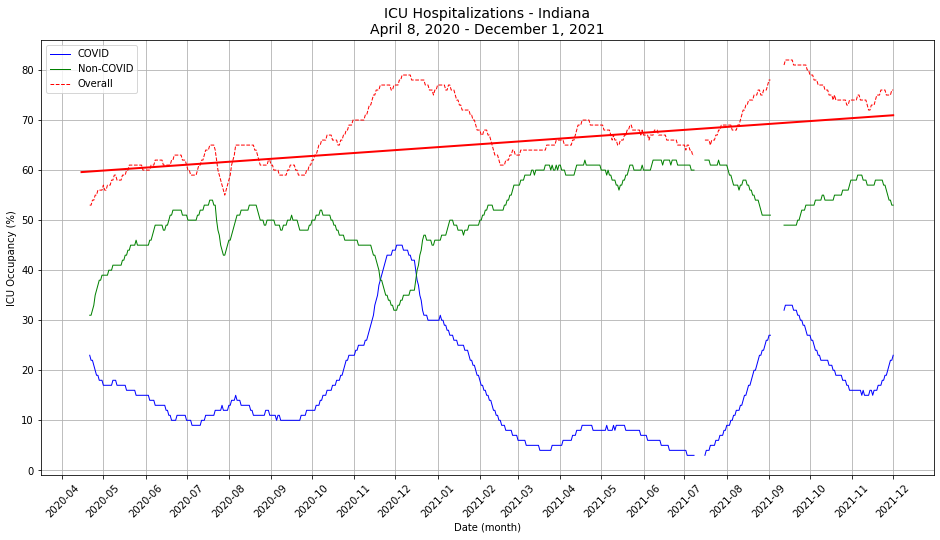

In [61]:
fig, ax = plt.subplots(figsize=(16, 8))

plt.plot(IN_hospitals['date'], IN_hospitals['rolling_ICU_occupancy_covid'], label = 'COVID', color = 'blue', lw = 1)
plt.plot(IN_hospitals['date'], IN_hospitals['rolling_ICU_occupancy_noncovid'], label = 'Non-COVID', color = 'green', lw = 1)
plt.plot(IN_hospitals['date'], IN_hospitals['rolling_ICU_occupancy'], label = 'Overall', color = 'red', lw = 1, ls = '--')

plt.plot(IN_hospitals['date'], preds, color="red", lw = 2)

ax.legend(loc = 'upper left', prop={'size': 10})
ax.set_ylabel('ICU Occupancy (%)')
ax.set_xlabel('Date (month)')
ax.xaxis.set_major_locator(dates.MonthLocator(interval = 1))
plt.xticks(rotation = 45)
plt.grid()

plt.title('ICU Hospitalizations - Indiana\nApril 8, 2020 - December 1, 2021', fontsize = 14)

__Interpretation:__ despite cancellation of elective procedures - hospitals in Indiana continued to experience increasingly higher ICU occupancy throughout the pandemic. This is even true in periods outside major COVID-19 waves in the state/county. This indicates long-term challenges meeting staffing needs and could have implications for patient outcomes.

### Vaccinations & COVID-19 Waves

__To Do:__ read in [data](https://hub.mph.in.gov/dataset/covid-19-vaccinations-by-date) from the IDOH on vaccinations by county by day & analyze vaccination rate compared to COVID-19 waves in Marion County.

__Note:__ as referenced earlier, vaccinations in Marion County became available to all residents age 16+ on 3/31/21. Additionally, the state has pushed-back on COVID vaccination mandates and at this time we will be assuming they have had no effect on vaccination rates in the state ([source](https://www.usnews.com/news/best-states/indiana/articles/2021-11-22/indiana-gop-bill-stymies-workplace-covid-19-vaccine-mandates)).

In [62]:
# read in vaccination data

vax_df = pd.read_csv('data/county-vaccinations-by-date.csv', low_memory=False)

print('shape:', vax_df.shape)

shape: (33277, 17)


In [63]:
# process the data
# filter to Marion County, drop columns

vax_df = vax_df[vax_df['county'] == 'Marion']
vax_df['fips'] = vax_df['fips'].astype(int)
vax_df = vax_df.drop(columns = ['county', 'region', 'fips', 'current_as_of'])
vax_df['date'] = pd.to_datetime(vax_df['date'])

vax_df.head()

,date,first_dose_administered,second_dose_administered,single_dose_administered,all_doses_administered,fully_vaccinated,booster_dose_administered,new_first_dose_administered,new_second_dose_administered,new_single_dose_administered,new_all_doses_administered,new_fully_vaccinated,new_booster_dose_administered
12,2020-12-14,3,0,0,3,0,0,0,0,0,0,0,0
42,2020-12-15,9,0,0,9,0,0,0,0,0,0,0,0
96,2020-12-16,154,0,0,154,0,0,0,0,0,0,0,0
167,2020-12-17,226,0,0,226,0,0,0,0,0,0,0,0
246,2020-12-18,1210,0,0,1210,0,0,0,0,0,0,0,0


In [64]:
# merge with main dataset on date

marion = pd.merge(marion, vax_df, on = 'date', how = 'left')

marion.tail()

,date,cumulative_cases,order_code,Face_Masks_Required_in_Public,cases_per_day,rolling_case_avg,active_cases,at_risk_pop,daily_infection_rate,daily_infection_rate_diff,...,single_dose_administered,all_doses_administered,fully_vaccinated,booster_dose_administered,new_first_dose_administered,new_second_dose_administered,new_single_dose_administered,new_all_doses_administered,new_fully_vaccinated,new_booster_dose_administered
636,2021-11-27,142556,NaN,False,0.0,195.0,3668.0,973535.0,0.000000,0.000000,...,5.0,1845.0,305.0,1205.0,1.0,2.0,0.0,3.0,2.0,0.0
637,2021-11-28,142556,NaN,False,0.0,195.0,3745.0,973458.0,0.000000,0.000000,...,9.0,1211.0,267.0,781.0,9.0,7.0,0.0,20.0,7.0,4.0
638,2021-11-29,143788,NaN,False,1232.0,264.0,3893.0,973310.0,0.126578,0.126578,...,26.0,3433.0,947.0,1908.0,25.0,26.0,0.0,95.0,26.0,44.0
639,2021-11-30,144163,NaN,False,375.0,274.0,4399.0,972804.0,0.038548,-0.088030,...,42.0,3744.0,906.0,2286.0,100.0,133.0,2.0,568.0,135.0,333.0
640,2021-12-01,144603,NaN,False,440.0,292.0,4399.0,972804.0,0.045230,0.006682,...,40.0,4524.0,820.0,3041.0,224.0,227.0,9.0,1643.0,236.0,1183.0


__To Do:__ compute vaccination rate & rolling averages for 1st doses & overall

__Note:__ first vaccine dose count is calculated by adding the `first_dose_administered` (indicating the 1st dose of a 2-dose vaccine series) to the `single_dose_administered` (indicating the first and only dose of a 1-dose vaccine) column for a given day.

In [65]:
marion['cumulative_vax'] = marion['all_doses_administered'].cumsum()
marion['rolling_vax_avg'] = marion['all_doses_administered'].rolling(window=7).mean().round()
marion['rolling_1st_dose_avg'] = (marion['first_dose_administered'] + marion['single_dose_administered']).rolling(window=7).mean().round()
marion['daily_1st_vax_rate'] =  (marion['rolling_1st_dose_avg'] / (total_pop) * 100)
marion['daily_vax_rate'] = (marion['all_doses_administered'] / (total_pop) * 100.0).fillna(method='ffill')

marion['daily_vax_rate_smoothed'] = (marion['rolling_vax_avg'] / total_pop * 100.0).fillna(0)
marion['daily_vaccination_rate_diff'] = marion['daily_vax_rate'].diff(periods = 1)

marion['daily_1st_vax_rate_smoothed'] = (marion['rolling_1st_dose_avg'] / total_pop * 100.0).fillna(0)
marion['daily_1st_vaccination_rate_diff'] = marion['daily_1st_vax_rate'].diff(periods = 1)


marion.reset_index(drop = True)

,date,cumulative_cases,order_code,Face_Masks_Required_in_Public,cases_per_day,rolling_case_avg,active_cases,at_risk_pop,daily_infection_rate,daily_infection_rate_diff,...,new_booster_dose_administered,cumulative_vax,rolling_vax_avg,rolling_1st_dose_avg,daily_1st_vax_rate,daily_vax_rate,daily_vax_rate_smoothed,daily_vaccination_rate_diff,daily_1st_vax_rate_smoothed,daily_1st_vaccination_rate_diff
0,2020-03-01,0,NaN,False,0.0,0.0,0.0,977203.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN
1,2020-03-02,0,NaN,False,0.0,0.0,0.0,977203.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN
2,2020-03-03,0,NaN,False,0.0,0.0,1.0,977202.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN
3,2020-03-04,0,NaN,False,0.0,0.0,1.0,977202.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN
4,2020-03-05,0,NaN,False,0.0,0.0,1.0,977202.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,2021-11-27,142556,NaN,False,0.0,195.0,3668.0,973535.0,0.000000,0.000000,...,0.0,1116097.0,2438.0,493.0,0.050450,0.188804,0.249488,-0.064879,0.050450,-0.007368
637,2021-11-28,142556,NaN,False,0.0,195.0,3745.0,973458.0,0.000000,0.000000,...,4.0,1117308.0,2401.0,477.0,0.048813,0.123925,0.245701,-0.064879,0.048813,-0.001637
638,2021-11-29,143788,NaN,False,1232.0,264.0,3893.0,973310.0,0.126578,0.126578,...,44.0,1120741.0,2384.0,461.0,0.047175,0.351309,0.243962,0.227384,0.047175,-0.001637
639,2021-11-30,144163,NaN,False,375.0,274.0,4399.0,972804.0,0.038548,-0.088030,...,333.0,1124485.0,2318.0,415.0,0.042468,0.383134,0.237208,0.031826,0.042468,-0.004707


__To Do:__ visualize any potential trend in vaccinations & compare to spikes in COVID-19 infection

__Note:__ we expect a rush on vaccinations when they first became available followed by a decline - what we are really interested in is any secondary spikes in vaccinations and the timeframe at which they occurred. This visual will only look at the time __after__ the 1st COVID-19 peak. Focus on the increase in vaccination rate following the blue line indicating the peak of the 2nd COVID-19 wave.

In [66]:
wave1_peak = pd.to_datetime('2020-12-01')
wave2_peak = pd.to_datetime('2021-09-01')

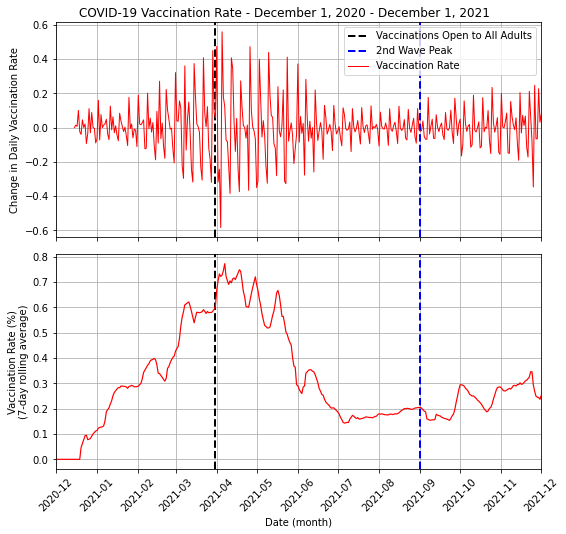

In [67]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize=(8, 7))

fig.suptitle('COVID-19 Vaccination Rate - December 1, 2020 - December 1, 2021',
             fontsize = 12, y = 1)
fig.subplots_adjust(hspace = 0.1)

ax[0].axvline(all_eligible_date, color='black',linestyle='--',label='Vaccinations Open to All Adults', lw = 2)
ax[0].axvline(wave2_peak, color='blue',linestyle='--',label='2nd Wave Peak', lw = 2)
ax[0].plot(marion['date'], marion['daily_vaccination_rate_diff'], label = 'Vaccination Rate', color = 'red', lw = 1)
ax[0].grid()
ax[0].set_ylabel('Change in Daily Vaccination Rate')
ax[0].legend(loc = 'upper right', prop={'size': 10})

ax[1].axvline(all_eligible_date, color='black',linestyle='--',label='Vaccinations Open to All Adults', lw = 2)
ax[1].axvline(wave2_peak, color='blue',linestyle='--',label='2nd Wave Peak', lw = 2)
ax[1].plot(marion['date'], marion['daily_vax_rate_smoothed'], label = 'Vaccination rate', color = 'red', lw = 1.2)
ax[1].grid()
ax[1].set_ylabel('Vaccination Rate (%)\n(7-day rolling average)')
ax[1].set_xlabel('Date (month)')
ax[1].xaxis.set_major_locator(dates.MonthLocator(interval = 1))

fig.tight_layout()
fig.subplots_adjust(top = 0.97)
ax[0].set_xlim([wave1_peak, max(marion['date'])])
plt.xticks(rotation = 45)
plt.show()